In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.externals import joblib
from sklearn import tree
from sklearn.grid_search import GridSearchCV

/home/expertsvision/Desktop/GA_implemented_with_flask/server/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/expertsvision/Desktop/GA_implemented_with_flask/server/venv/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def get_time(x, c1, c2):     #find the difference between two date columns of dataframe x
    diff =  x[c2] - x[c1]
    days = diff.days
    days_to_hours = days * 24
    diff_btw_two_times = (diff.seconds) / 3600
    overall_hours = days_to_hours + diff_btw_two_times
    return overall_hours

In [3]:
file = 'CF Data For ML - OCT 2018_OrgID.xlsx'
data = pd.ExcelFile(file)
df = data.parse('Order History_1')

In [4]:
col_names= ['Created Time', 'Delivered Time','Total Orders to Assign', 'Qty']
df.dropna(subset=col_names, how='any', inplace = True)
df['Hours2deliver']= df.apply(get_time, c1='Created Time', c2='Delivered Time', axis=1)

In [142]:
from sklearn.metrics import make_scorer
tree_regression_Model = tree.DecisionTreeRegressor(random_state=0)
scoring = make_scorer(r2_score)
parameters={'max_depth': np.arange(5, 20), 'min_samples_split':np.arange(30, 45)}
#cross_validation = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(tree_regression_Model, parameters, cv=10, n_jobs=4, refit=True, scoring=scoring,verbose=1)

In [143]:
#grid_search = tree.DecisionTreeRegressor(criterion='mae', random_state=0, max_depth=19, min_samples_split=45)
grid_search.fit(X_trn,Y_trn)

Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=4)]: Done 1504 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 2250 out of 2250 | elapsed:    6.5s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'min_samples_split': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]), 'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(r2_score),
       verbose=1)

In [144]:
print(grid_search.best_params_)
print(grid_search.best_estimator_.feature_importances_)

{'min_samples_split': 34, 'max_depth': 8}
[0.03315285 0.58972944 0.02058413 0.07535583 0.28117775]


In [88]:
#predict_model = trained_model.predict(X_tst)
predict_model = grid_search.best_estimator_.predict(X_tst)

<H2> Convert time in to 2 dimension (sine and cosine) because of cyclic nature of time <H2>

In [5]:
#sorted_df = df.sort_values(by=['Created Time'])
created_week, created_day, df['created_time'] = zip(*[(d.dayofweek, d.date().day, 
                                                 d.date()) for d in df['Created Time']])
#sorted_df = sorted_df.assign(created_week=created_week, created_day=created_day, created_time=created_time)

In [6]:
#sorted_df = df.sort_values(by=['Delivered Time'])
deliver_week, deliver_day, df['deliver_time'] = zip(*[(d.dayofweek, d.date().day, d.date()) 
                                                                    for d in df['Delivered Time']])
#sorted_df = sorted_df.assign(deliver_week=deliver_week, deliver_day=deliver_day, deliver_time=deliver_time)

In [7]:
df['diff'] = df['Created Time'] - df['created_time'].apply(pd.to_datetime)

In [8]:
df['seconds'] = df['diff'].dt.total_seconds()

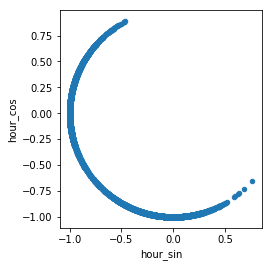

In [9]:
df['hour_sin'] = np.sin(2 * np.pi * df['seconds']/86400.0)
df['hour_cos'] = np.cos(2 * np.pi * df['seconds']/86400.0)
df.plot.scatter('hour_sin','hour_cos').set_aspect('equal');

In [10]:
df['del_diff'] = df['Delivered Time'] - df['deliver_time'].apply(pd.to_datetime)
df['del_seconds'] = df['del_diff'].dt.total_seconds() 

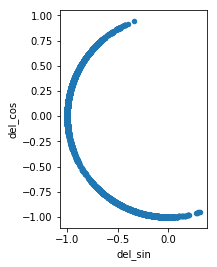

In [11]:
df['del_sin'] = np.sin(2 * np.pi * df['del_seconds']/86400.0)
df['del_cos'] = np.cos(2 * np.pi * df['del_seconds']/86400.0)
df.plot.scatter('del_sin','del_cos').set_aspect('equal');

In [24]:
X = df[['Qty', 'Location Code','Total Orders to Assign', 'hour_sin', 'hour_cos']].values
Y = df[['del_sin', 'del_cos']].values
# = df['Hours2deliver'].values
#X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=0.3, random_state=42)
X_trn = X[0:3500, :]
X_tst = X[3500:,:]
Y_trn = Y[0:3500, :]
Y_tst = Y[3500:,:]

In [25]:
tree_regression_model = tree.DecisionTreeRegressor(max_depth=8, min_samples_split=34)
trained_model = tree_regression_model.fit(X_trn, Y_trn)

In [26]:
predict_model = trained_model.predict(X_tst)

In [27]:
print("Mean squared error: "  )
mse= mean_squared_error(Y_tst, predict_model,)
print(mse)
print('r2')
r2 = r2_score(Y_tst, predict_model, sample_weight=None, multioutput='uniform_average')
print(r2)
adj_r2 = 1-(1-r2) * (X_tst.shape[0] -1)/(X_tst.shape[0]-X_tst.shape[1] -1)
adj_r2

Mean squared error: 
0.051803087978383636
r2
0.7578787490068262


0.7567598892517746

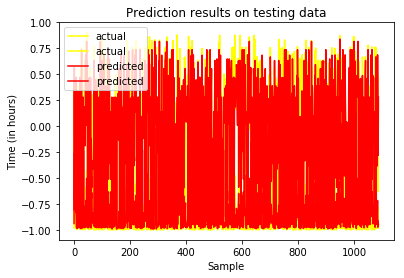

In [28]:
plt.plot(Y_tst, color= 'yellow', label= 'actual') # p
plt.plot(predict_model, color= 'red', label= 'predicted') # p
plt.xlabel('Sample')
plt.ylabel('Time (in hours)')
plt.title('Prediction results on testing data')
plt.legend()
plt.show()

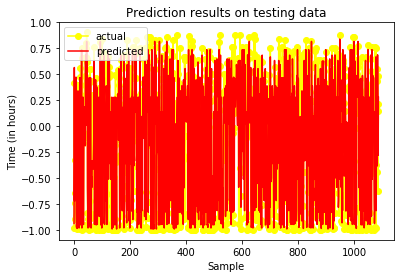

In [29]:
plt.plot(Y_tst[:,1],  color= 'yellow',marker='o', label= 'actual') # p
plt.plot(predict_model[:,1], color= 'red', label= 'predicted') # p
plt.xlabel('Sample')
plt.ylabel('Time (in hours)')
plt.title('Prediction results on testing data')
plt.legend()
plt.show()

In [56]:
Y_tst[:,0]

array([-0.20271601, -0.90844742, -0.67376514, ..., -0.98860364,
       -0.77792333, -0.97678148])

In [44]:
df['del_seconds'][3500:3510]

3511    46006.999
3512    70729.999
3513    53365.999
3514    55177.000
3515    60194.999
3516    49487.999
3517    50417.999
3518    62334.999
3519    66673.000
3520    46397.000
Name: del_seconds, dtype: float64

In [46]:
df['del_sin'][3500:3510]

3511   -0.202716
3512   -0.908447
3513   -0.673765
3514   -0.764968
3515   -0.944448
3516   -0.441506
3517   -0.501133
3518   -0.983976
3519   -0.990738
3520   -0.230404
Name: del_sin, dtype: float64

In [49]:
total_seconds=60*60*24
sine_sec = np.abs((np.arcsin(predict_model[:,0]))*(total_seconds/2*np.pi))

In [50]:
cosine_sec = np.abs((np.arcsin(predict_model[:,1]))*(total_seconds/2*np.pi))

In [51]:
sine_autal_sec = np.abs((np.arcsin(Y_tst[:,0]))*(total_seconds/2*np.pi))

In [52]:
cosine_autal_sec = np.abs((np.arcsin(Y_tst[:,1]))*(total_seconds/2*np.pi))

In [53]:
df1 = pd.DataFrame()
df1['sine_sec'] = sine_sec
df1['sine_autal_sec'] = sine_autal_sec
df1['cosine_sec'] = cosine_sec
df1['cosine_autal_sec'] = cosine_autal_sec

In [54]:
df1.to_csv('model1_time_comparison.csv', sep=',', index=False)

In [55]:
df1.head(10)

,sine_sec,sine_autal_sec,cosine_sec,cosine_autal_sec
0,36310.945660,27703.969684,165171.541849,185479.485379
1,127968.913866,154656.710835,81510.507625,58526.744229
2,92039.159321,100334.388472,108602.268303,112849.066592
3,98899.808681,118208.251912,2716.616496,94975.203152
4,92039.159321,167733.916927,108602.268303,45449.538137
5,100735.845151,62060.062604,86341.415742,151123.392459
6,100735.845151,71238.794697,86341.415742,141944.660366
7,134068.088617,188854.870345,66784.471729,24328.584718
8,64175.902559,194697.686020,132765.912041,18485.769043
9,20667.693711,31553.125270,183250.128871,181630.329793


In [128]:
import datetime
str(datetime.timedelta(seconds=25406))

'7:03:26'

In [129]:
str(datetime.timedelta(seconds=2793.098046))

'0:46:33.098046'

In [101]:
str(datetime.timedelta(seconds=93005.77080))

'1 day, 1:50:05.770800'

In [125]:
str(datetime.timedelta(seconds=58996))

'16:23:16'

In [108]:
np.sum(sine_sec>86400)

996

In [109]:
np.sum(sine_autal_sec>86400)

953

In [110]:
np.sum(cosine_autal_sec>86400)

622

In [111]:
np.sum(cosine_sec>86400)

551

In [126]:
test = df['del_seconds'].values

In [132]:
np.sum(test < 800)

0

In [57]:
np.sin(3.34265)

-0.19970548942551575